In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, median_absolute_error, accuracy_score
from nocarz.config import PROCESSED_DATA_DIR

from collections import defaultdict


In [69]:
TEXT_COLUMNS = ["name", "description", "neighbourhood"]
NUMERICAL_COLUMNS = ["accommodates", "bathrooms", "bedrooms", "beds", "price"]
CATEGORICAL_COLUMNS = ["property_type", "room_type", "bathrooms_text"]

train = pd.read_csv(PROCESSED_DATA_DIR / "train.csv")
test = pd.read_csv(PROCESSED_DATA_DIR / "test.csv")

train = train.dropna(subset=NUMERICAL_COLUMNS + CATEGORICAL_COLUMNS).reset_index(drop=True)

for col in TEXT_COLUMNS:
    train[col] = train[col].fillna("")
    test[col] = test[col].fillna("")

vectorizer = TfidfVectorizer(max_features=1000)
X_train_text = vectorizer.fit_transform(train[TEXT_COLUMNS].agg(" ".join, axis=1))
X_test_text = vectorizer.transform(test[TEXT_COLUMNS].agg(" ".join, axis=1))


In [70]:
y_train_reg = train[NUMERICAL_COLUMNS]
y_test_reg = test[NUMERICAL_COLUMNS]

le_dict = {}
y_train_cls = pd.DataFrame()
y_test_cls = pd.DataFrame()

for col in CATEGORICAL_COLUMNS:
    le = LabelEncoder()
    y_train_cls[col] = le.fit_transform(train[col].astype(str))
    most_common = train[col].mode()[0]
    safe_test = test[col].apply(lambda x: x if x in le.classes_ else most_common)
    y_test_cls[col] = le.transform(safe_test.astype(str))
    le_dict[col] = le

regressor = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))

regressor.fit(X_train_text, y_train_reg)
classifier.fit(X_train_text, y_train_cls)


MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

In [71]:
y_pred_reg = regressor.predict(X_test_text)
y_pred_cls = classifier.predict(X_test_text)

metrics = {}

for i, col in enumerate(NUMERICAL_COLUMNS):
    mask = ~y_test_reg[col].isna()
    y_true = y_test_reg[col][mask]
    y_pred = y_pred_reg[:, i][mask]
    metrics[col] = {
        "mean_absolute_error": mean_absolute_error(y_true, y_pred),
        "median_absolute_error": median_absolute_error(y_true, y_pred),
        "count": len(y_true)
    }

for i, col in enumerate(CATEGORICAL_COLUMNS):
    acc = accuracy_score(y_test_cls[col], y_pred_cls[:, i])
    metrics[col] = {
        "accuracy": acc,
        "count": len(y_test_cls[col])
    }

import pprint
pprint.pprint(metrics)


{'accommodates': {'count': 552,
                  'mean_absolute_error': 0.8460800983436854,
                  'median_absolute_error': np.float64(0.6800000000000002)},
 'bathrooms': {'count': 405,
               'mean_absolute_error': 0.23454024103468546,
               'median_absolute_error': np.float64(0.1100000000000001)},
 'bathrooms_text': {'accuracy': 0.657608695652174, 'count': 552},
 'bedrooms': {'count': 499,
              'mean_absolute_error': 0.39938352896268725,
              'median_absolute_error': np.float64(0.22999999999999998)},
 'beds': {'count': 404,
          'mean_absolute_error': 0.6180615865157945,
          'median_absolute_error': np.float64(0.43666666666666654)},
 'price': {'count': 405,
           'mean_absolute_error': 62.41486566725455,
           'median_absolute_error': np.float64(32.09)},
 'property_type': {'accuracy': 0.7663043478260869, 'count': 552},
 'room_type': {'accuracy': 0.9130434782608695, 'count': 552}}


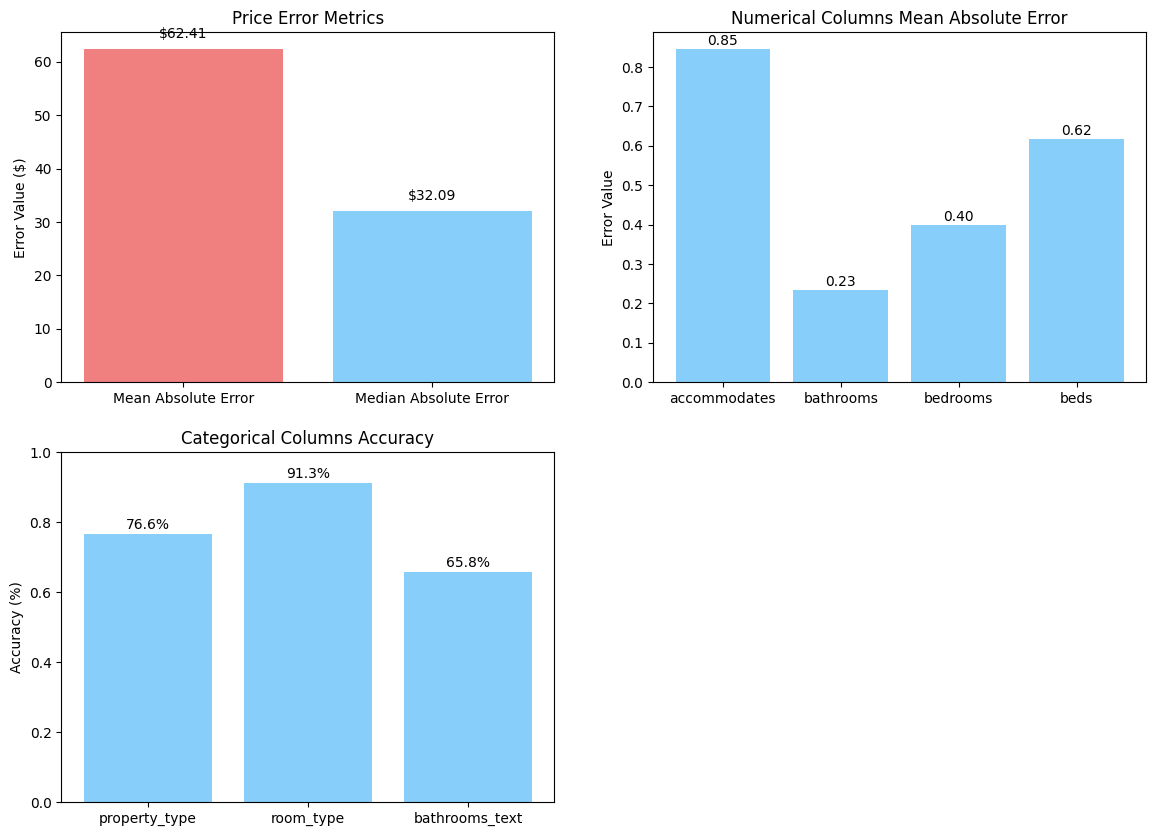

In [79]:
import matplotlib.pyplot as plt

# Maska tylko dla wierszy z nie-NaN w price
mask_price = ~y_test_reg["price"].isna()
true_price = y_test_reg["price"][mask_price]
pred_price = y_pred_reg[:, NUMERICAL_COLUMNS.index("price")][mask_price]

# MAE i median MAE
price_mae = mean_absolute_error(true_price, pred_price)
price_med = np.median(np.abs(true_price - pred_price))

plt.figure(figsize=(14, 10))

# 1. MAE / MedAE dla ceny
plt.subplot(2, 2, 1)
plt.bar(["Mean Absolute Error", "Median Absolute Error"], [price_mae, price_med], color=["lightcoral", "lightskyblue"])
plt.ylabel("Error Value ($)")
plt.title("Price Error Metrics")
plt.text(0, price_mae + 2, f"${price_mae:.2f}", ha="center")
plt.text(1, price_med + 2, f"${price_med:.2f}", ha="center")

# 2. MAE dla pozostałych kolumn liczbowych
plt.subplot(2, 2, 2)
non_price_cols = [col for col in NUMERICAL_COLUMNS if col != "price"]
non_price_maes = []
for col in non_price_cols:
    mask = ~y_test_reg[col].isna()
    val = mean_absolute_error(y_test_reg[col][mask], y_pred_reg[:, NUMERICAL_COLUMNS.index(col)][mask])
    non_price_maes.append(val)

plt.bar(non_price_cols, non_price_maes, color="lightskyblue")
plt.title("Numerical Columns Mean Absolute Error")
plt.ylabel("Error Value")
for i, val in enumerate(non_price_maes):
    plt.text(i, val + 0.01, f"{val:.2f}", ha="center")

# 3. Accuracy dla kolumn kategorycznych
plt.subplot(2, 2, 3)
accs = [accuracy_score(y_test_cls[col], y_pred_cls[:, i]) for i, col in enumerate(CATEGORICAL_COLUMNS)]
plt.bar(CATEGORICAL_COLUMNS, accs, color="lightskyblue")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 1)
plt.title("Categorical Columns Accuracy")
for i, val in enumerate(accs):
    plt.text(i, val + 0.015, f"{val:.1%}", ha="center")



In [81]:
print("=" * 60)
print("MODEL EVALUATION RESULTS SUMMARY")
print("=" * 60)

print("Numerical Columns MAE:")
for i, col in enumerate(NUMERICAL_COLUMNS):
    mask = ~y_test_reg[col].isna()
    mae = mean_absolute_error(y_test_reg[col][mask], y_pred_reg[:, i][mask])
    print(f"{col}: {mae:.2f}")

print("\nCategorical Columns Accuracy:")
for i, col in enumerate(CATEGORICAL_COLUMNS):
    acc = accuracy_score(y_test_cls[col], y_pred_cls[:, i])
    print(f"{col}: {acc:.2%}")


MODEL EVALUATION RESULTS SUMMARY
Numerical Columns MAE:
accommodates: 0.85
bathrooms: 0.23
bedrooms: 0.40
beds: 0.62
price: 62.41

Categorical Columns Accuracy:
property_type: 76.63%
room_type: 91.30%
bathrooms_text: 65.76%


In [ ]:
import pickle
from nocarz.config import MODELS_DIR

regressor_path = MODELS_DIR / "random_forest_regressor.pkl"
classifier_path = MODELS_DIR / "random_forest_classifier.pkl"
vectorizer_path = MODELS_DIR / "tfidf_vectorizer.pkl"
label_encoders_path = MODELS_DIR / "label_encoders.pkl"

with open(regressor_path, "wb") as f:
    pickle.dump(regressor, f)

with open(classifier_path, "wb") as f:
    pickle.dump(classifier, f)

with open(vectorizer_path, "wb") as f:
    pickle.dump(vectorizer, f)

with open(label_encoders_path, "wb") as f:
    pickle.dump(le_dict, f)

print("Model components saved to individual files:")
print(f"- Regressor: {regressor_path}")
print(f"- Classifier: {classifier_path}")
print(f"- Vectorizer: {vectorizer_path}")
print(f"- Label encoders: {label_encoders_path}")


Model components saved to individual files:
- Regressor: /home/michal/Desktop/sem6/ium25l/models/random_forest_regressor.pkl
- Classifier: /home/michal/Desktop/sem6/ium25l/models/random_forest_classifier.pkl
- Vectorizer: /home/michal/Desktop/sem6/ium25l/models/tfidf_vectorizer.pkl
- Label encoders: /home/michal/Desktop/sem6/ium25l/models/label_encoders.pkl
